# Import packages

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

import re
import nltk
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import words

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline

[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>


# Load data

In [2]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

In [3]:
print('Training set dimension:', df_train.shape)
print('Test set dimension:', df_test.shape)

Training set dimension: (40000, 4)
Test set dimension: (10000, 4)


In [4]:
df_train.head()

,file_id,review,sentiment,polarity
0,neg_10939_3.txt,This movie has some of the worst acting that ...,neg,0
1,pos_5631_8.txt,Kudos to Fawcett to taking on roles that at t...,pos,1
2,pos_8298_8.txt,I m serious as well I mean don t get me wrong...,pos,1
3,pos_9373_9.txt,Like many of you I am a great fan of the real...,pos,1
4,neg_4956_1.txt,it s embarrassing I had like 3 minutes on my ...,neg,0


# Preprocessing

In [5]:
def prep(review):
    review = BeautifulSoup(review, 'html.parser').get_text()        # Remove HTML tags.
    review = re.sub("[^a-zA-Z0-9]", " ", review)                    # Remove non-letters
    review = review.lower()                                         # Lower case
    token = nltk.word_tokenize(review)                              # Tokenize to each word.
    review = [nltk.stem.SnowballStemmer('english').stem(w) for w in token]     # Stemming
    # Join the words back into one string separated by space, and return the result.
    return " ".join(review)

In [6]:
# test whether the function successfully preprocessed.
print(df_train['review'][0])
print('')
print(prep(df_train['review'][0]))

 This movie has some of the worst acting that I have ever seen Some scenes are original such as the nails coming through the floor This nail trap catches these bad guys The rest of the movie degrades as you go I can t believe that this movie is not even in the bottom 100 movies of all time I also can t believe that there are sequels The next crap movie that I want to watch is R O T O R Could R O T O R really be much worse than this br br 

this movi has some of the worst act that i have ever seen some scene are origin such as the nail come through the floor this nail trap catch these bad guy the rest of the movi degrad as you go i can t believ that this movi is not even in the bottom 100 movi of all time i also can t believ that there are sequel the next crap movi that i want to watch is r o t o r could r o t o r realli be much wors than this br br


In [7]:
df_train['clean'] = df_train['review'].apply(prep)
df_test['clean'] = df_test['review'].apply(prep)

In [8]:
df_train['clean'].iloc[3]

'like mani of you i am a great fan of the real thing the 1940s noir film but red rock west was a real treat for all of us long for the past the term neo noir has been so often use inappropri in the last ten year that it has lost it mean and it impact john dahl s film on the other hand truli deserv to be describ as such the cast is perfect all around and would have felt right at home with tay garnett or jacqu tourneur the plot is so tight that you are hook within the first fifteen minut jame m cain would have appreci it mani contemporari film leav me wonder whi they don t make them like they use to and i m not even that old movi such as red rock west give us hope for the futur while pay tribut to the past'

In [9]:
print('Training dim:', df_train.shape, 'Test dim:', df_test.shape)

Training dim: (40000, 5) Test dim: (10000, 5)


# TF-IDF

TF-IDF (Term Frequency - Inverse Document Frequency) can be represented tf(d,t) X idf(t). TF-IDF uses the method diminishing the weight (importance) of words appeared in many documents in common, considered them incapable of discerning the documents, rather than simply counting the frequency of words as CountVectorizer does. The outcome matrix consists of each document (row) and each word (column) and the importance (weight) computed by tf * idf (values of the matrix).


In [10]:
# analyzer is the parameter that the vectorizer reads the input data in word unit or character unit to create a matrix
# vocabulary is the parameter that the vectorizer creates the matrix by using only input data or some other source 
# Other parameters are self-explanatory and already mentioned in other notebooks.
tv = TfidfVectorizer(ngram_range = (1,3),
                     sublinear_tf = True,
                     max_features = 40000)

In [11]:
# Handle with care especially when you transform the test dataset. (Wrong: fit_transform(df_test))
train_tv = tv.fit_transform(df_train['clean'])
test_tv = tv.transform(df_test['clean'])

In [12]:
# Create the list of vocabulary used for the vectorizer.
vocab = tv.get_feature_names()
print(vocab[:5])

['00', '000', '000 000', '007', '10']


In [13]:
print("Vocabulary length:", len(vocab))

Vocabulary length: 40000


In [14]:
dist = np.sum(train_tv, axis=0)
checking = pd.DataFrame(dist,columns = vocab)

In [15]:
checking

,00,000,000 000,007,10,10 10,10 and,10 becaus,10 br,10 br br,...,zombi,zombi and,zombi film,zombi in,zombi movi,zone,zoom,zoom in,zorro,zucco
0,10.845736,24.69361,3.927915,3.617498,224.629544,28.712945,9.984345,8.229298,19.420829,19.420829,...,55.60279,5.65399,4.157347,4.001224,9.315986,16.002694,8.188846,3.527663,3.970329,3.327121


As you can see the above, due to the vocabulary option 'set(words.words())', a lot of vocabularies are added to the matrix even more than review's vocabularies.

In [16]:
print('Training dim:', train_tv.shape, 'Test dim:', test_tv.shape)

Training dim: (40000, 40000) Test dim: (10000, 40000)


# Visualization

## WordCloud
As alluded in the first notebook, the drawback for WordCloud is that the graphics only reflect the frequency of words, which can cause some uninformative words frequently appeared in the text can be highlighted on the cloud instead of informative words which is less frequently appeared in the text. These kind of uninformative words could be stopwords or just some words frequently appeared in documents that particularly longer than other documents. Although the WordCloud is not the best visualization method to show all the aspect of the data, it is worth plotting them so that we can quickly and intuitively see what the text is about.

In [17]:
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    

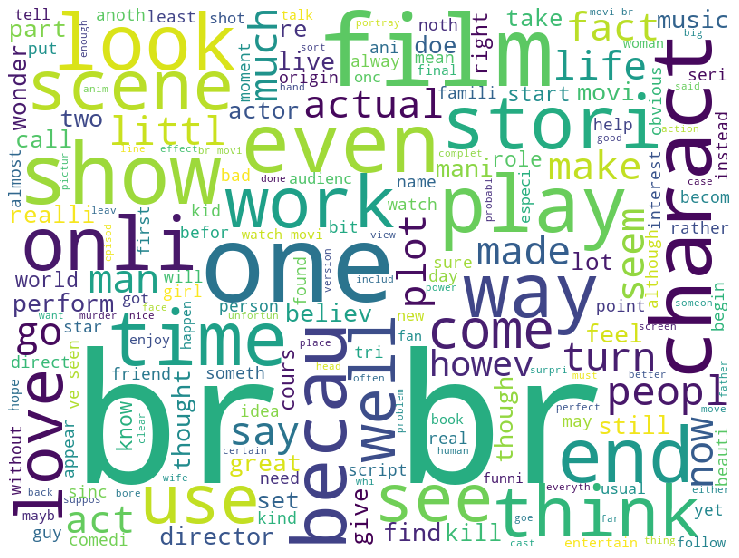

In [18]:
cloud(' '.join(df_train['clean']))

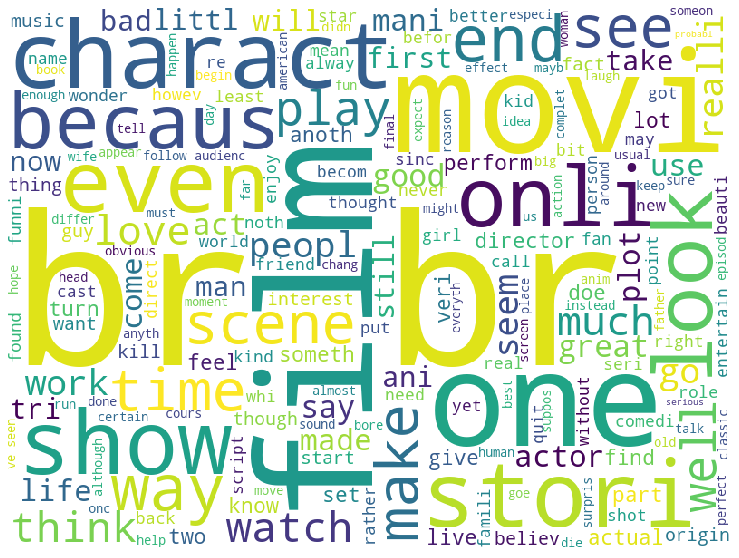

In [19]:
cloud(' '.join(df_test['clean']))

As expected, most of emphasized words are just normal words like "film", "one", "movie", "show", and "stori" which appear to be not informative to distinguish one document from the others or distinguish between negative and positive movie reviews.

## Distribution

In [20]:
# We need to split each words in cleaned review and then count the number of each rows of data frame.
df_train['freq_word'] = df_train['clean'].apply(lambda x: len(str(x).split()))
df_train['unique_freq_word'] = df_train['clean'].apply(lambda x: len(set(str(x).split())))
                                                 
df_test['freq_word'] = df_test['clean'].apply(lambda x: len(str(x).split()))
df_test['unique_freq_word'] = df_test['clean'].apply(lambda x: len(set(str(x).split())))                                                 

median of word frequency:  179.0
median of uniuqe word frequency:  113.0


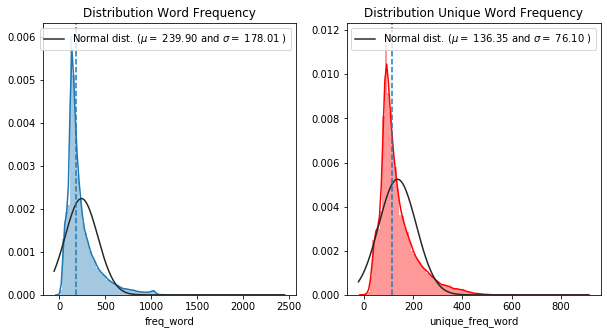

In [21]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(10,5)

sns.distplot(df_train['freq_word'], bins = 90, ax=axes[0], fit = stats.norm)
(mu0, sigma0) = stats.norm.fit(df_train['freq_word'])
axes[0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu0, sigma0)],loc='best')
axes[0].set_title("Distribution Word Frequency")
axes[0].axvline(df_train['freq_word'].median(), linestyle='dashed')
print("median of word frequency: ", df_train['freq_word'].median())


sns.distplot(df_train['unique_freq_word'], bins = 90, ax=axes[1], color = 'r', fit = stats.norm)
(mu1, sigma1) = stats.norm.fit(df_train['unique_freq_word'])
axes[1].set_title("Distribution Unique Word Frequency")
axes[1].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu1, sigma1)],loc='best')
axes[1].axvline(df_train['unique_freq_word'].median(), linestyle='dashed')
print("median of uniuqe word frequency: ", df_train['unique_freq_word'].median())

The black contour of the distribution graphs represent the normal distribution if the data would have been distributed as normal. Compared to the black contour, the actual distribution is pretty skwed; therefore, median would be better to use as a measure of representative of data since mean is very sensitive to outliers and noise especially the distribution is highly skewed. As shown in the legend, the mean of the word frequency is 236.89 and the mean of the unique word is 135.61. It means 236.89 words and 135.61 unique words are used for each review. Also the dashed lines represent the median of the distribution. Another thing to notice is that the median values are very closely located to the normal distribution's mean points. Compared to CountVectorizer methods, there are 117.39 words used more for train set and 41.57 words used more for test set. This is due to the different parameter setting and we used more words for max features for TF-IDF. The distribution of the graphs are somehow similar to that of CountVectorizer.

# Modeling
As text data usually is very sparse and has a high dimensionality, using linear, and simple models such as Linear Support Vector Machine, Bernoulli Naive Bayes, Logistic Regression or MultiLayer Perceptron would be better choice rather than using Random Forest. 

## Support Vector Machine - Linear

In [22]:
param_grid = {'loss':['squared_hinge'],
              'class_weight':[{1:4}],
              'C': [0.2]
             }

svm = GridSearchCV(LinearSVC(random_state=5), 
                   param_grid = [param_grid], verbose = 1, cv = 5, n_jobs = -1, scoring = 'roc_auc')
svm.fit(train_tv, df_train['polarity'])
svm_best = svm.best_estimator_
print(svm.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


{'C': 0.2, 'class_weight': {1: 4}, 'loss': 'squared_hinge'}


In [23]:
svm_submission = svm.predict(test_tv)

In [24]:
print(svm.best_score_)

0.9694651520740195


## Naive Bayes Classifier - Bernoulli

In [25]:
param_grid = {'alpha': [0.001],
              'binarize': [0.001]}

nb = GridSearchCV(BernoulliNB(), 
                  param_grid = [param_grid], verbose = 1, cv = 5, n_jobs = -1, scoring = "roc_auc")
nb.fit(train_tv, df_train['polarity'])
nb_best = nb.best_estimator_
print(nb.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


{'alpha': 0.001, 'binarize': 0.001}


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


In [26]:
nb_submission = nb.predict(test_tv)

In [27]:
print(nb.best_score_)

0.9412309959489897


## MLP

In [28]:
param_grid = {'hidden_layer_sizes':[(5)],
              'activation':['relu'],
              'solver':['adam'],
              'alpha':[0.3],
              'learning_rate':['constant'],
              'max_iter':[1000]
             }

MLP = GridSearchCV(MLPClassifier(random_state = 5),
                     param_grid = param_grid, verbose = 1, cv = 5, n_jobs = -1, scoring = "roc_auc")
MLP.fit(train_tv,df_train['polarity'])
print(MLP.best_params_)
mlp_best = MLP.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min finished


{'activation': 'relu', 'alpha': 0.3, 'hidden_layer_sizes': 5, 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}


In [29]:
mlp_submission = MLP.predict(test_tv)

In [30]:
print(MLP.best_score_)

0.9681127763793201


## Logistic Regression

In [31]:
param_grid = {'penalty':['l2'],
                  'dual':[True],
                  'C':[6],
                  'class_weight':[{1:1}]
                 }

lr = GridSearchCV(LogisticRegression(random_state = 5),
                     param_grid = [param_grid], verbose = 1, cv = 5, n_jobs = -1, scoring = "roc_auc")
lr.fit(train_tv, df_train['polarity'])
print(lr.best_params_)
logi_best = lr.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 6, 'class_weight': {1: 1}, 'dual': True, 'penalty': 'l2'}


In [32]:
lr_submission = lr.predict(test_tv)

In [33]:
print(lr.best_score_)

0.9697604150515855


### Investigating Model Coefficients
Since there are 40000 features, it is impossible to look at all of the coefficients at the same time. Therefore, we can sort them and look at the largest coefficients. The following bar chart shows the 30 largest and 30 smallest coefficients of the Logistic Regression model, with the bars showing the size of each coefficients.

In [34]:
# Extract the coefficients from the best model Logistic Regression and sort them by index.
coefficients = logi_best.coef_
index = coefficients.argsort()

In [35]:
# Extract the feature names.
feature_names = np.array(tv.get_feature_names())

In [36]:
# From the smallest to largest.
feature_names[index][0][:30]

array(['bad', 'worst', 'aw', 'poor', 'bore', 'disappoint', 'wast',
       'terribl', 'the worst', 'horribl', 'noth', 'wors', 'dull',
       'stupid', 'ridicul', 'save', 'sorri', 'lame', 'pointless', 'fail',
       'annoy', 'mediocr', 'embarrass', 'lack', 'not worth', 'mess',
       'cheap', 'forgett', 'clich', 'oh'], dtype='<U24')

In [37]:
# From the smallest to largest.
feature_names[index][0][-31::1]

array(['appreci', 'especi', 'touch', 'this is', 'favorit', 'best',
       'subtl', 'definit worth', 'entertain', 'delight', 'love',
       'definit', 'gem', 'love this', 'superb', 'refresh', 'must see',
       'well worth', 'fun', 'surpris', 'high recommend', 'fantast',
       'enjoy', 'hilari', 'today', 'amaz', 'brilliant', 'beauti',
       'perfect', 'excel', 'great'], dtype='<U24')

In [38]:
# feature names: Smallest 30 + largest 30.
feature_names_comb = list(feature_names[index][0][:30]) + list(feature_names[index][0][-31::1])

In [39]:
# coefficients magnitude: Smallest 30 + largest 30.
index_comb = list(coefficients[0][index[0][:30]]) + list(coefficients[0][index[0][-31::1]])

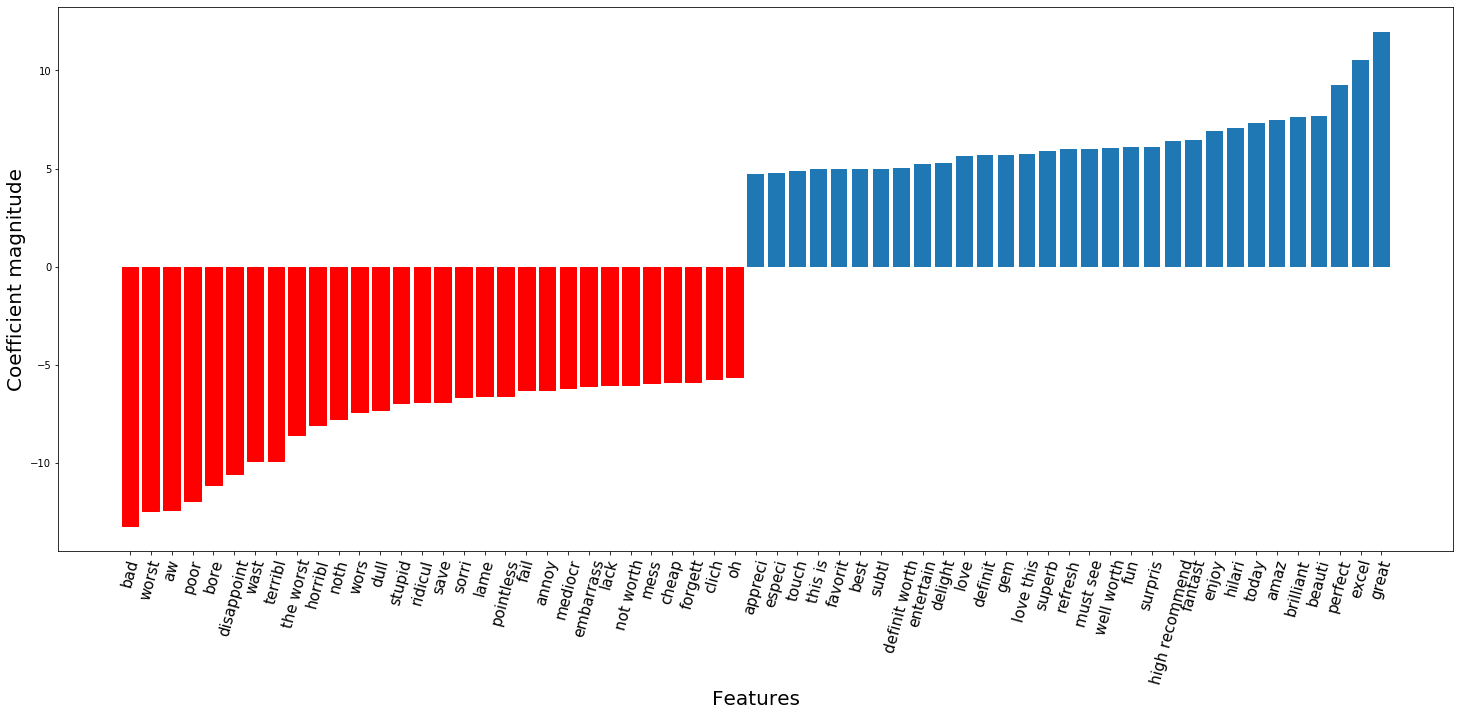

In [40]:
# Make sure the x-axis be the number from 0 to the length of the features selected not the feature names.
# Once the bar is plotted, the features are placed as ticks.
plt.figure(figsize=(25,10))
barlist = plt.bar(list(i for i in range(61)), index_comb)
plt.xticks(list(i for i in range(61)),feature_names_comb,rotation=75,size=15)
plt.ylabel('Coefficient magnitude',size=20)
plt.xlabel('Features',size=20)

# color the first smallest 30 bars red
for i in range(30):
    barlist[i].set_color('red')

plt.show()

As mentioned in previous notebook about CountVectorizer, the blue bar indicates positive movie reviews. On the other hand the red bar indicates negative move reviews. Interestingly, there are many words in common on both barplot based on CountVectorizer and TF-IDF such as: worst, bad, aw, wast, disappoint, excel, perfect, great, high recommend, etc.

## Summary of results

In [41]:
pd.DataFrame({'Modelling' : ['Linear SVM', 'NB','MLP','LR'],
              'Score' : [svm.best_score_, nb.best_score_, MLP.best_score_,lr.best_score_]})

,Modelling,Score
0,Linear SVM,0.969465
1,NB,0.941231
2,MLP,0.968113
3,LR,0.969760
